In [99]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import locale
import numpy as np
from numpy import pi as PI
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mpd
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import pandas as pd
import pysolar
import pytz
import re
import seaborn as sns
import statsmodels.api as sm
from scipy.signal import medfilt
from time import time, sleep

from prettyprinting import *
from datacharm.dataplots import tableau20, ch_color
from enerpi.base import timeit
from enerpi.api import enerpi_data_catalog
import datetime as dt
import ephem


sns.set_style('whitegrid')
TZ = pytz.timezone('Europe/Madrid')
LAT = 38.631463
LONG = -0.866402
ELEV_M = 500
FS = (16, 10)

here = ephem.Observer()
sun, moon = ephem.Sun(), ephem.Moon()
now = pd.Timestamp.now(tz=TZ)
#here.date = dt.dat
here.lat = str(LAT)
here.lon = str(LONG)
here.elevation = ELEV_M

print(ephem.localtime(here.previous_rising(sun)), ephem.localtime(here.date))

sun.compute(here)
moon.compute(here)
print_yellow("%s %s" % (sun.alt, sun.az))
print_cyan("%s %s" % (moon.alt, moon.az))

2016-09-19 07:48:27 2016-09-19 22:11:52
-24:57:57.1 293:28:53.4
0:27:09.2 77:23:13.2


In [70]:
math.degrees(sun.alt), math.degrees(sun.az)

(-22.076928463645196, 290.4896392875565)

In [86]:
ephem.localtime(ephem.Date(now.tz_convert('UTC'))), now.to_datetime()

(datetime.datetime(2016, 9, 19, 21, 59, 1),
 datetime.datetime(2016, 9, 19, 21, 59, 1, 448061, tzinfo=<DstTzInfo 'Europe/Madrid' CEST+2:00:00 DST>))

In [133]:
# PYSOLAR Calc both altitude & azimut:
from pysolar.solar import *

def pysolar_fast_altitude_azimuth(latitude_deg, longitude_deg, when, fast=True, elevation=0,
                                  temperature=constants.standard_temperature, pressure=constants.standard_pressure):
    # expect 19 degrees for solar.get_altitude(42.364908,-71.112828,datetime.datetime(2007, 2, 18, 20, 13, 1, 130320))
    if fast:
        day = when.utctimetuple().tm_yday
        declination_rad = math.radians(get_declination(day))
        latitude_rad = math.radians(latitude_deg)
        hour_angle_rad = math.radians(get_hour_angle(when, longitude_deg))
        altitude_rad = math.radians(get_altitude_fast(latitude_deg, longitude_deg, when))
        try:
            azimuth_deg = math.degrees(math.asin(math.cos(declination_rad) * math.sin(hour_angle_rad)
                                                 / math.cos(altitude_rad)))
        except ValueError as e:
            print('Error {} in {}'.format(e, when))
            azimuth_deg = get_azimuth(latitude_deg, longitude_deg, when)
        if (math.cos(hour_angle_rad) >= (math.tan(declination_rad) / math.tan(latitude_rad))):
            return math.degrees(altitude_rad), azimuth_deg
        else:
            return math.degrees(altitude_rad), 180 - azimuth_deg
    else:
        # location-dependent calculations
        projected_radial_distance = get_projected_radial_distance(elevation, latitude_deg)
        projected_axial_distance = get_projected_axial_distance(elevation, latitude_deg)

        # time-dependent calculations
        jd = time.get_julian_solar_day(when)
        jde = time.get_julian_ephemeris_day(when)
        jce = time.get_julian_ephemeris_century(jde)
        jme = time.get_julian_ephemeris_millennium(jce)
        geocentric_latitude = get_geocentric_latitude(jme)
        geocentric_longitude = get_geocentric_longitude(jme)
        sun_earth_distance = get_sun_earth_distance(jme)
        aberration_correction = get_aberration_correction(sun_earth_distance)
        equatorial_horizontal_parallax = get_equatorial_horizontal_parallax(sun_earth_distance)
        nutation = get_nutation(jce)
        apparent_sidereal_time = get_apparent_sidereal_time(jd, jme, nutation)
        true_ecliptic_obliquity = get_true_ecliptic_obliquity(jme, nutation)

        # calculations dependent on location and time
        apparent_sun_longitude = get_apparent_sun_longitude(geocentric_longitude, nutation, aberration_correction)
        geocentric_sun_right_ascension = get_geocentric_sun_right_ascension(apparent_sun_longitude,
                                                                            true_ecliptic_obliquity,
                                                                            geocentric_latitude)
        geocentric_sun_declination = get_geocentric_sun_declination(apparent_sun_longitude, true_ecliptic_obliquity,
                                                                    geocentric_latitude)
        local_hour_angle = get_local_hour_angle(apparent_sidereal_time, longitude_deg,
                                                geocentric_sun_right_ascension)
        parallax_sun_right_ascension = get_parallax_sun_right_ascension(projected_radial_distance,
                                                                        equatorial_horizontal_parallax,
                                                                        local_hour_angle,
                                                                        geocentric_sun_declination)
        topocentric_local_hour_angle = get_topocentric_local_hour_angle(local_hour_angle,
                                                                        parallax_sun_right_ascension)
        topocentric_sun_declination = get_topocentric_sun_declination(geocentric_sun_declination,
                                                                      projected_axial_distance,
                                                                      equatorial_horizontal_parallax,
                                                                      parallax_sun_right_ascension,
                                                                      local_hour_angle)
        topocentric_elevation_angle = get_topocentric_elevation_angle(latitude_deg, topocentric_sun_declination,
                                                                      topocentric_local_hour_angle)
        refraction_correction = get_refraction_correction(pressure, temperature, topocentric_elevation_angle)
        altitude = topocentric_elevation_angle + refraction_correction
        azimuth = 180 - get_topocentric_azimuth_angle(topocentric_local_hour_angle, latitude_deg,
                                                      topocentric_sun_declination)
        return altitude, azimuth


compute_alt_azi_ephem TOOK: 0.025 s


/Users/uge/anaconda/envs/py35/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


compute_alt_azi_pysolar TOOK: 0.388 s
compute_alt_azi_pysolar_fast TOOK: 0.025 s
compute_alt_azi_pysolar_nch TOOK: 0.771 s
compute_alt_azi_pysolar_nch_fast TOOK: 0.395 s
                           altitude_e   azimuth_e
2016-09-05 00:00:00+02:00  -36.485303  321.118065
2016-09-05 00:01:00+02:00  -36.607785  321.386929
2016-09-05 00:02:00+02:00  -36.729551  321.656721
2016-09-05 00:03:00+02:00  -36.850592  321.927470
2016-09-05 00:04:00+02:00  -36.970909  322.199120
                           altitude_ps  azimuth_ps
2016-09-05 00:00:00+02:00   -36.487614 -141.123069
2016-09-05 00:01:00+02:00   -36.610083 -141.391957
2016-09-05 00:02:00+02:00   -36.731835 -141.661776
2016-09-05 00:03:00+02:00   -36.852864 -141.932528
2016-09-05 00:04:00+02:00   -36.973166 -142.204214
                           altitude_psf  azimuth_psf
2016-09-05 00:00:00+02:00    -37.075220   219.041860
2016-09-05 00:01:00+02:00    -37.197874   218.770693
2016-09-05 00:02:00+02:00    -37.319807   218.498575
2016-09-05 0

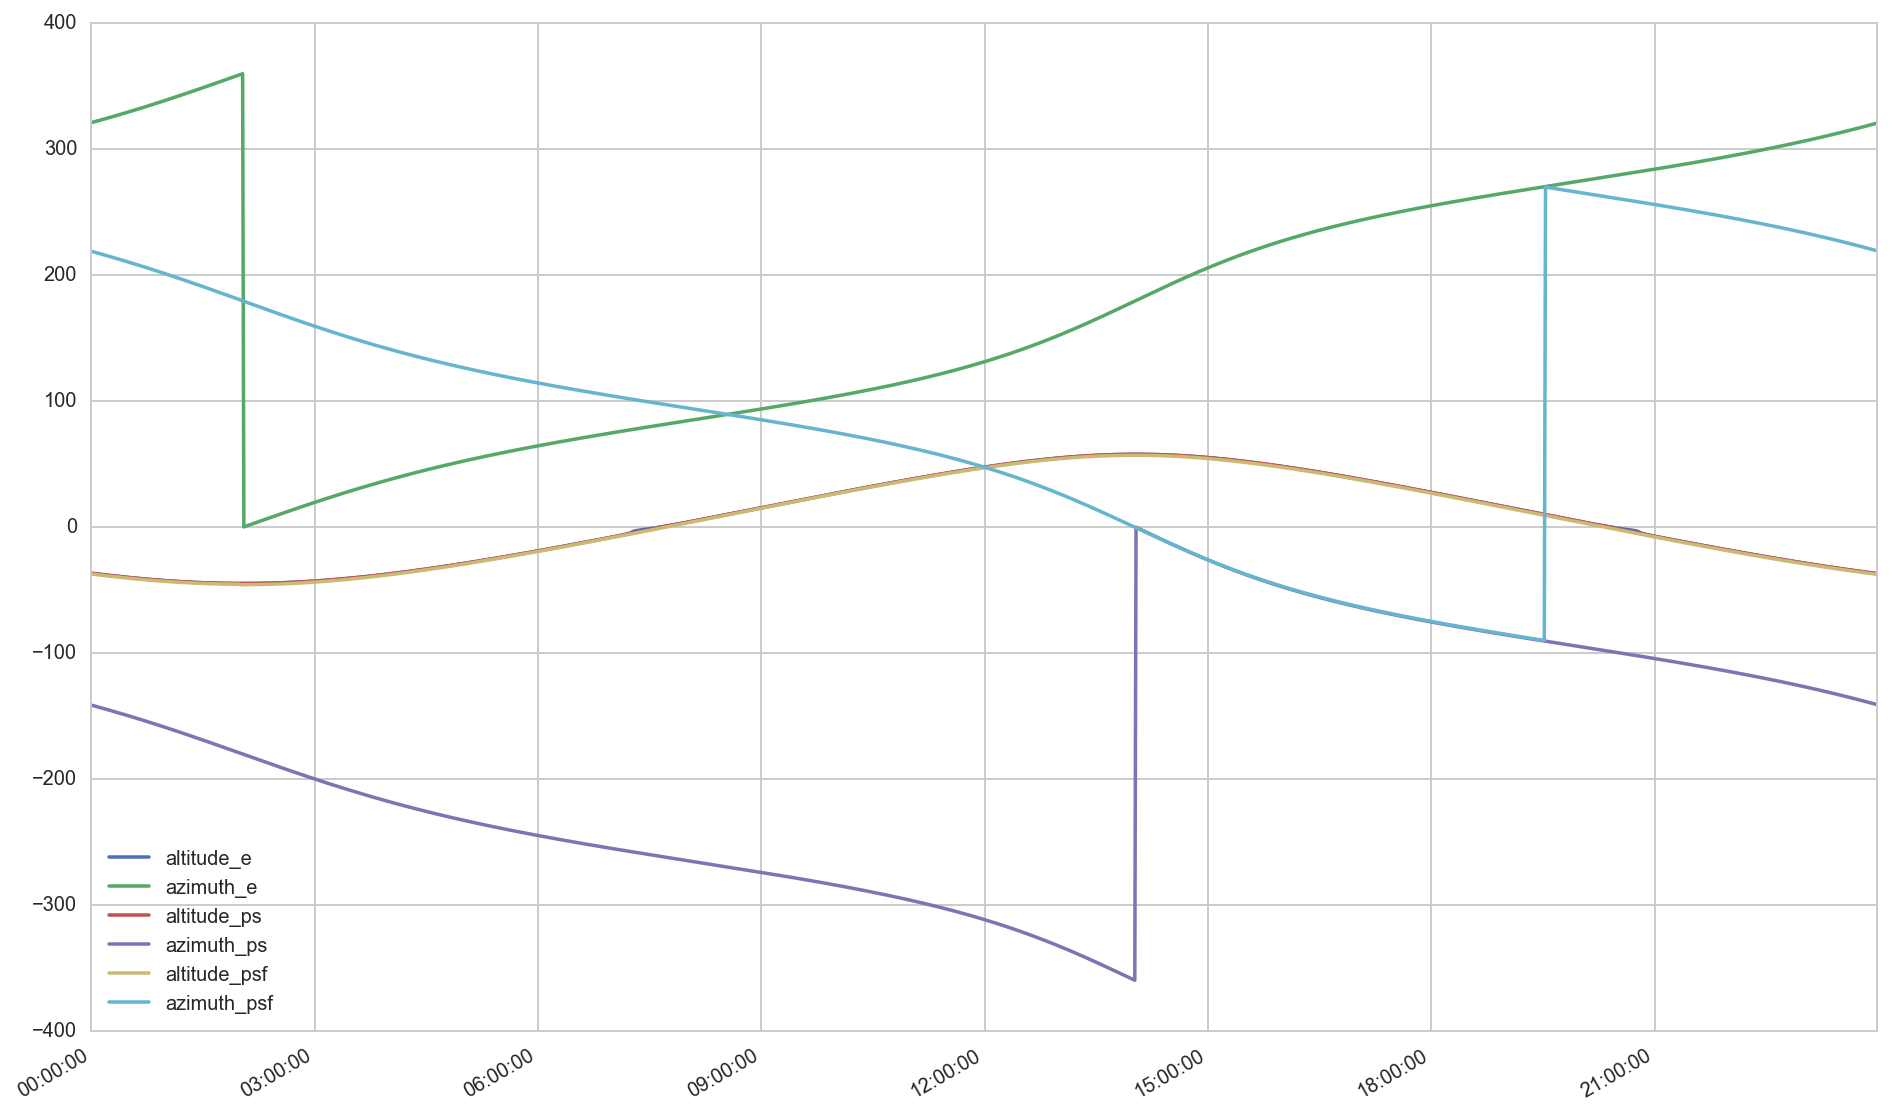

In [134]:
# PLOT DAY (y compara con PYSOLAR)

@timeit('compute_alt_azi_ephem', verbose=True)
def _compute_alt_azi_ephem(tt):
    tt_utc = tt.tz_convert('UTC')
    here = ephem.Observer()
    here.lat = str(LAT)
    here.lon = str(LONG)
    here.elevation = ELEV_M
    sun = ephem.Sun()
    
    date_alt_azi = np.zeros((len(tt), 2))
    for i, t in enumerate(tt_utc):
        here.date = ephem.Date(t)
        sun.compute(here)
        date_alt_azi[i, 0] = math.degrees(sun.alt)
        date_alt_azi[i, 1] = math.degrees(sun.az)
    return pd.DataFrame(date_alt_azi, columns=['altitude_e', 'azimuth_e'], index=tt)
    

@timeit('compute_alt_azi_pysolar', verbose=True)
def _compute_alt_azi_pysolar(tt):
    alt_azi = np.zeros((len(tt), 2))
    for i, t in enumerate(tt):
        alt_azi[i, :] = pysolar_fast_altitude_azimuth(LAT, LONG, t, fast=False, elevation=ELEV_M)
    return pd.DataFrame(alt_azi, columns=['altitude_ps', 'azimuth_ps'], index=tt)


@timeit('compute_alt_azi_pysolar_fast', verbose=True)
def _compute_alt_azi_pysolar_f(tt):
    alt_azi = np.zeros((len(tt), 2))
    for i, t in enumerate(tt):
        alt_azi[i, :] = pysolar_fast_altitude_azimuth(LAT, LONG, t, fast=True, elevation=ELEV_M)
    return pd.DataFrame(alt_azi, columns=['altitude_psf', 'azimuth_psf'], index=tt)


@timeit('compute_alt_azi_pysolar_nch', verbose=True)
def _compute_alt_azi_pysolar_nch(tt):
    alt_azi = np.zeros((len(tt), 2))
    for i, t in enumerate(tt):
        alt_azi[i, 0] = pysolar.solar.get_altitude(LAT, LONG, t, elevation=ELEV_M)
        alt_azi[i, 1] = pysolar.solar.get_azimuth(LAT, LONG, t, elevation=ELEV_M)
    return pd.DataFrame(alt_azi, columns=['altitude_ps_classic', 'azimuth_ps_classic'], index=tt)


@timeit('compute_alt_azi_pysolar_nch_fast', verbose=True)
def _compute_alt_azi_pysolar_nch_fast(tt):
    alt_azi = np.zeros((len(tt), 2))
    for i, t in enumerate(tt):
        alt_azi[i, 0] = pysolar.solar.get_altitude_fast(LAT, LONG, t)
        alt_azi[i, 1] = pysolar.solar.get_azimuth_fast(LAT, LONG, t)
    return pd.DataFrame(alt_azi, columns=['altitude_psf_classic', 'azimuth_psf_classic'], index=tt)



str_day = '2016-09-05'
tt = pd.DatetimeIndex(freq='1min', start=str_day, periods=60*24, tz=TZ)

df_ephem = _compute_alt_azi_ephem(tt)
df_ps = _compute_alt_azi_pysolar(tt)
df_psf = _compute_alt_azi_pysolar_f(tt)
df_ps_nch = _compute_alt_azi_pysolar_nch(tt)
df_ps_nch_f = _compute_alt_azi_pysolar_nch_fast(tt)

print_magenta(df_ephem.head())
print_red(df_ps.head())
print_cyan(df_psf.head())

ax = df_ephem.plot(figsize=FS)
df_ps.plot(ax=ax)
df_psf.plot(ax=ax)

In [120]:
compara = pd.concat([df_ephem, df_ps, df_psf, df_ps_nch, df_ps_nch_f], axis=1)
cols_alt = compara.columns[compara.columns.str.contains('alt')]
cols_azi = compara.columns[compara.columns.str.contains('azi')]

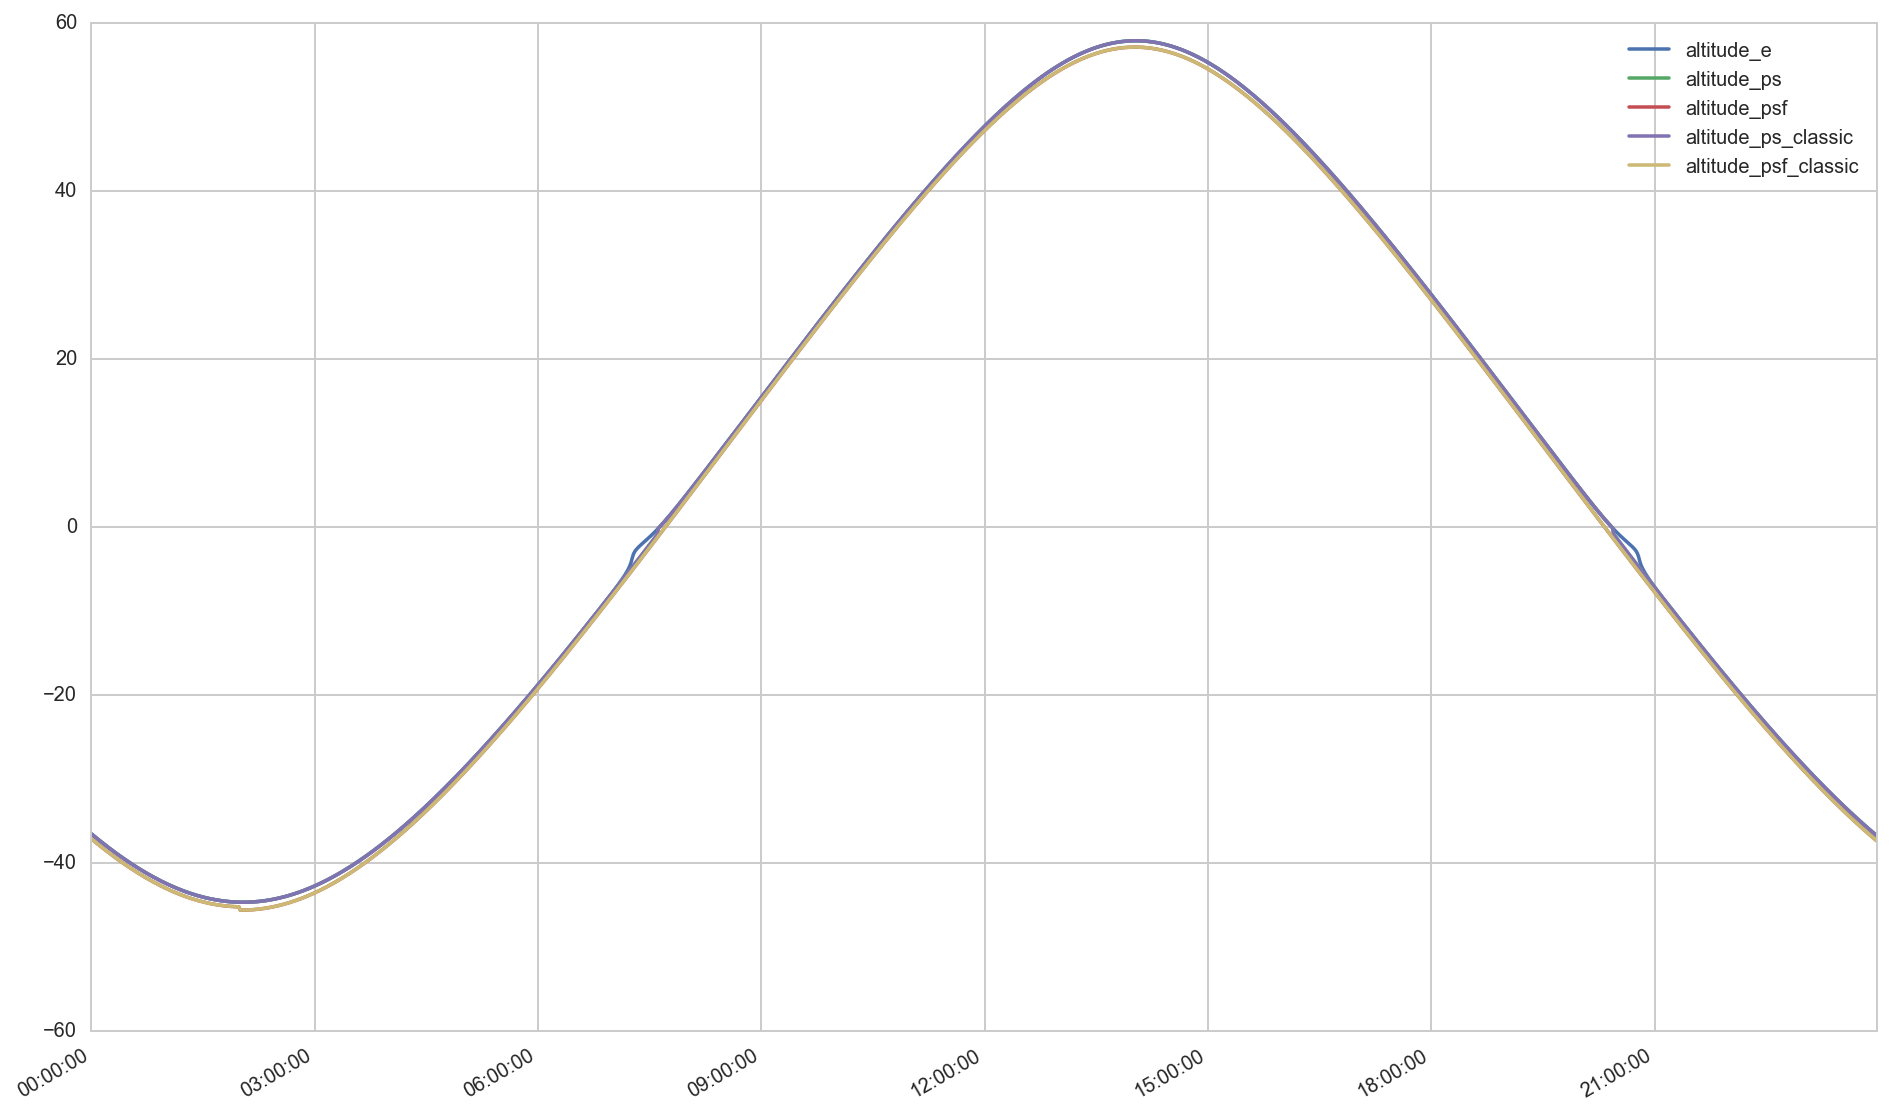

In [121]:
compara[cols_alt].plot(figsize=FS)

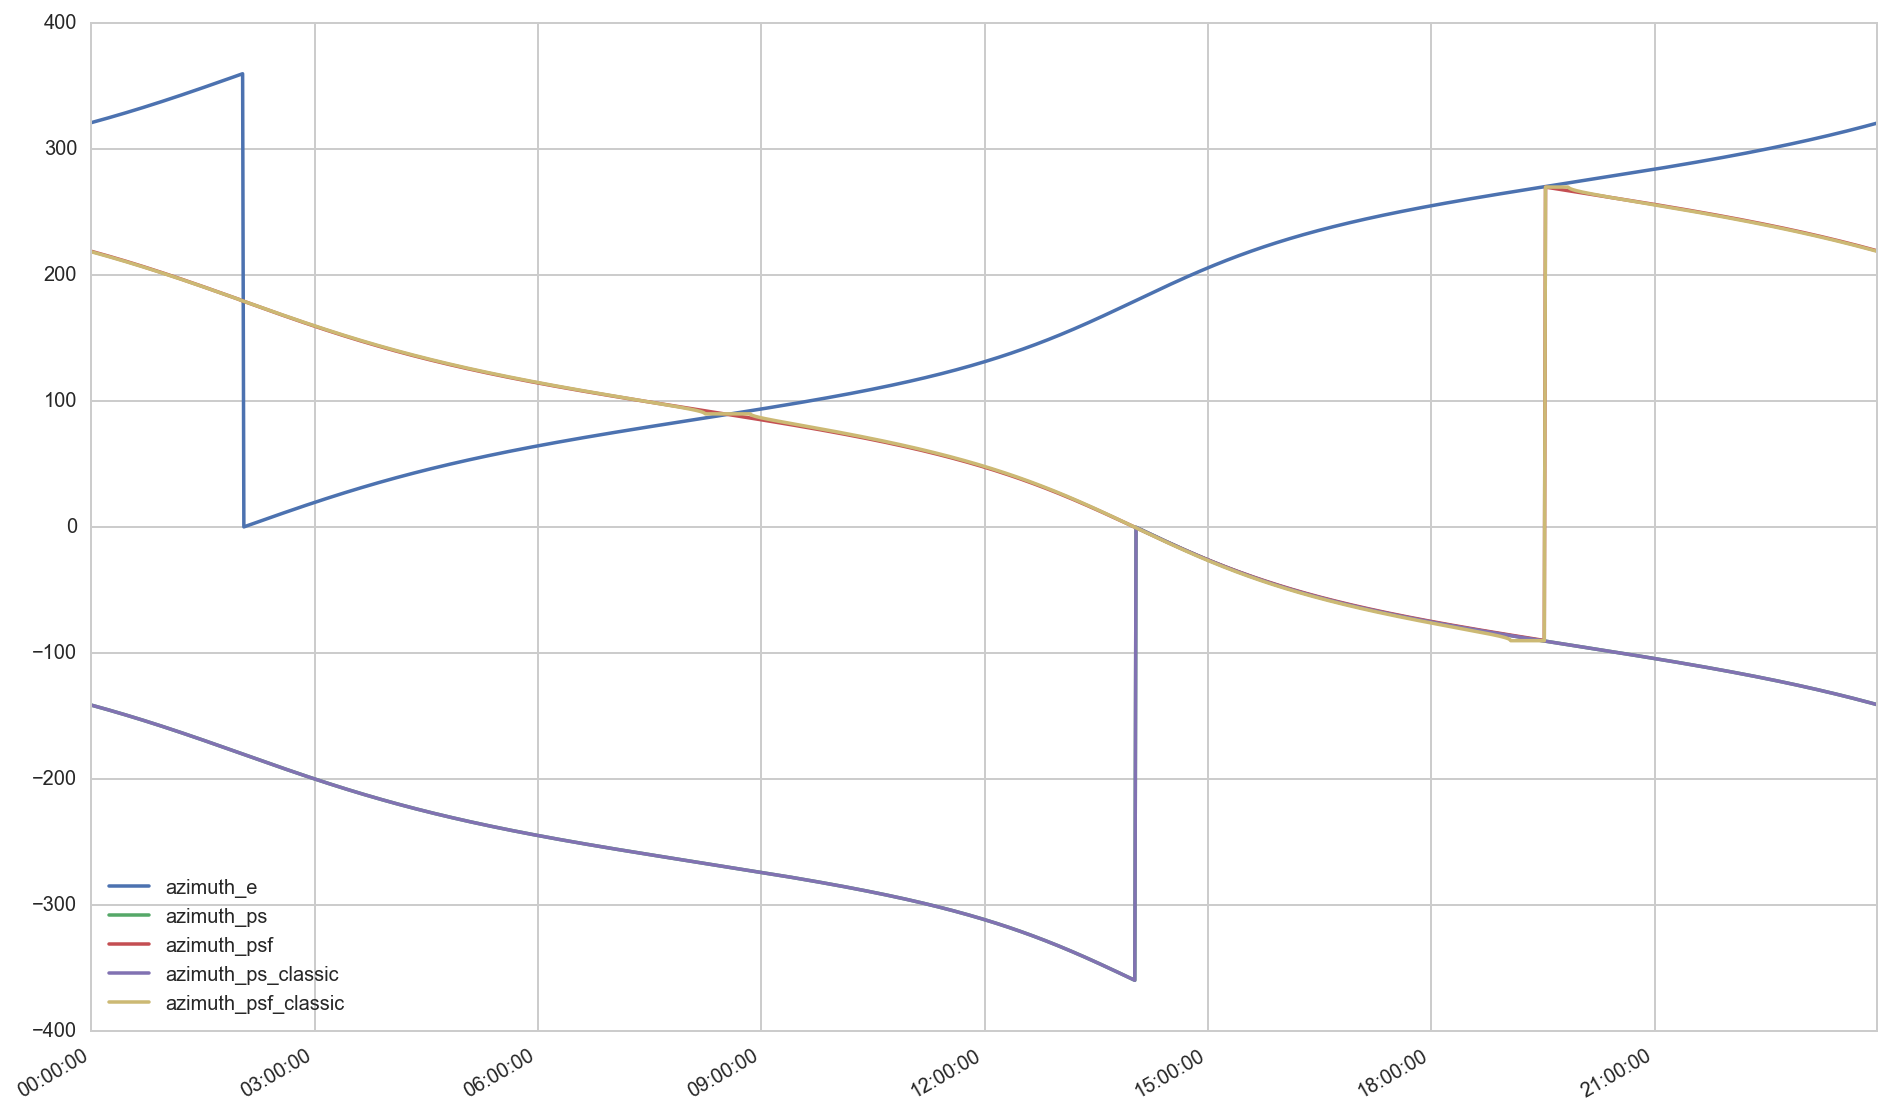

In [122]:
compara[cols_azi].plot(figsize=FS)

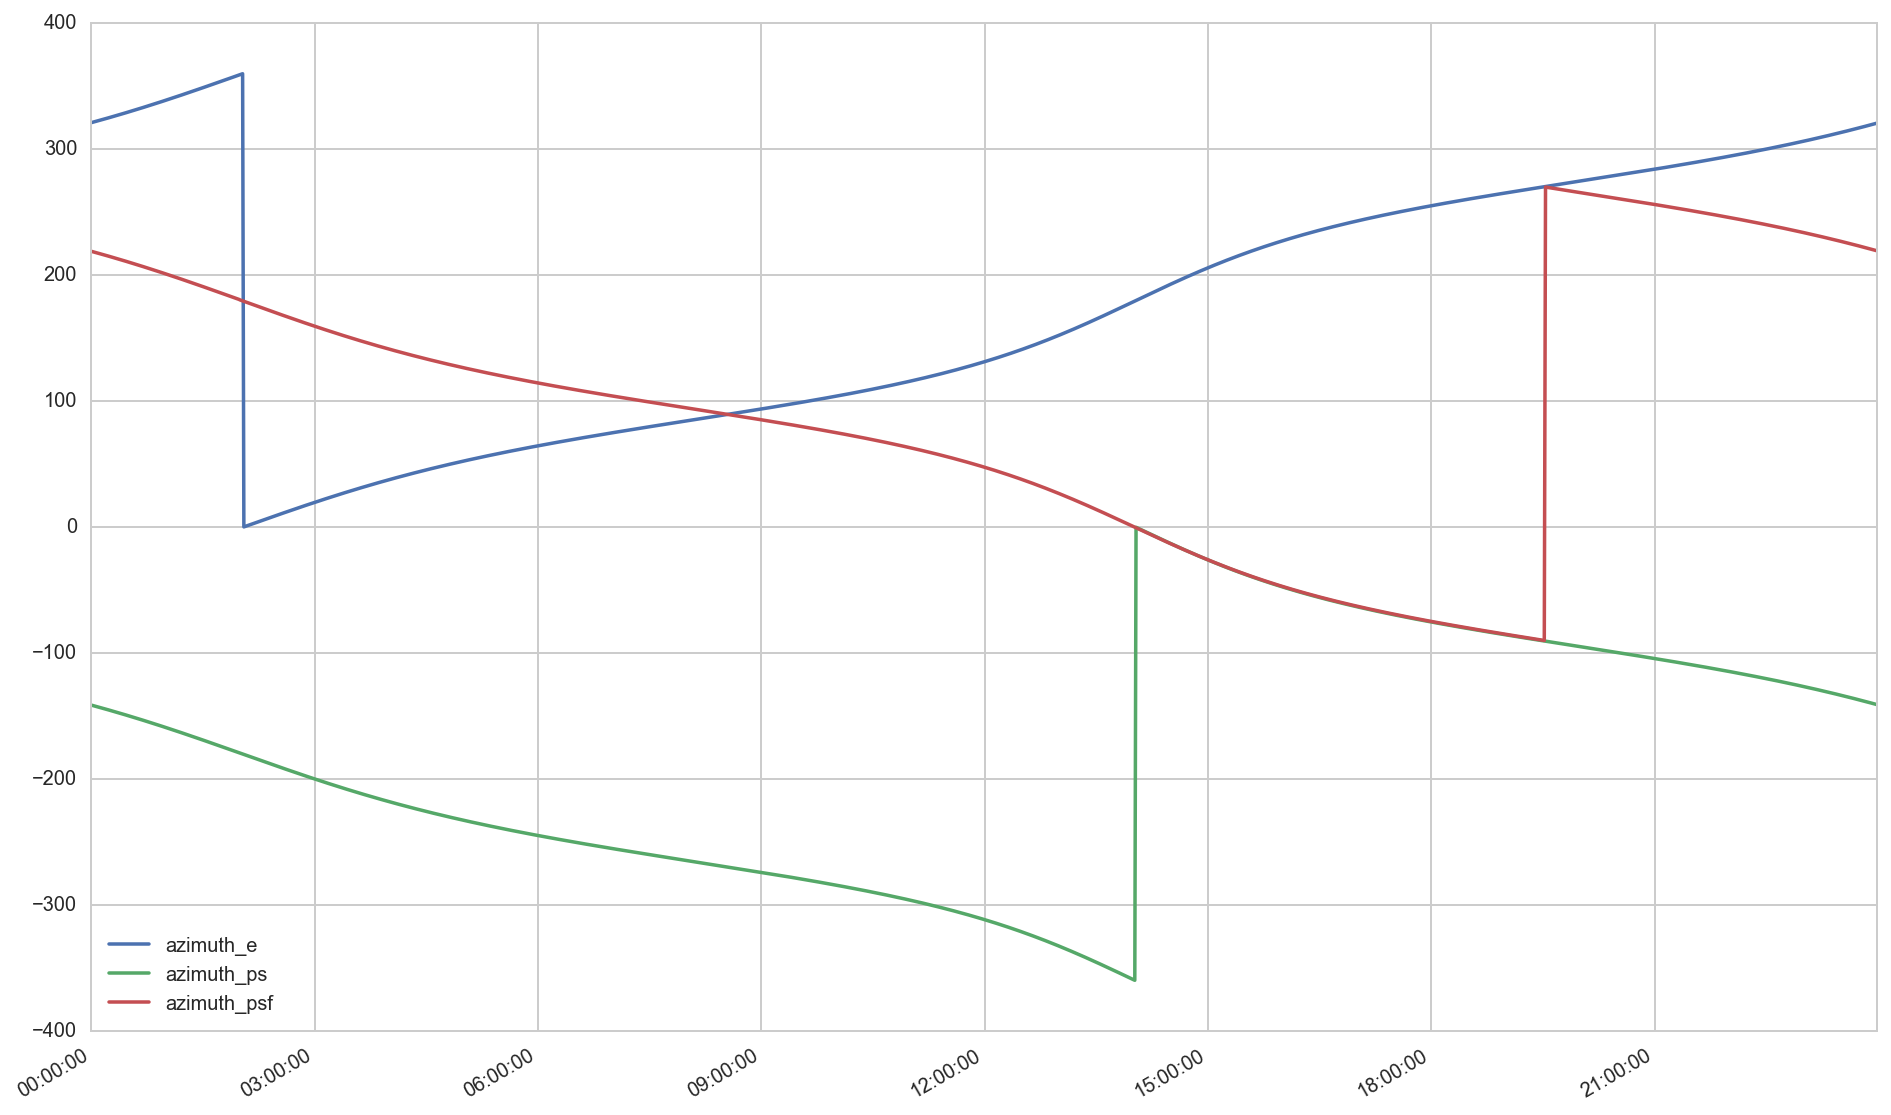

In [199]:
c_azimuts = ['azimuth_e', 'azimuth_ps', 'azimuth_psf']
compara[c_azimuts].plot(figsize=FS)

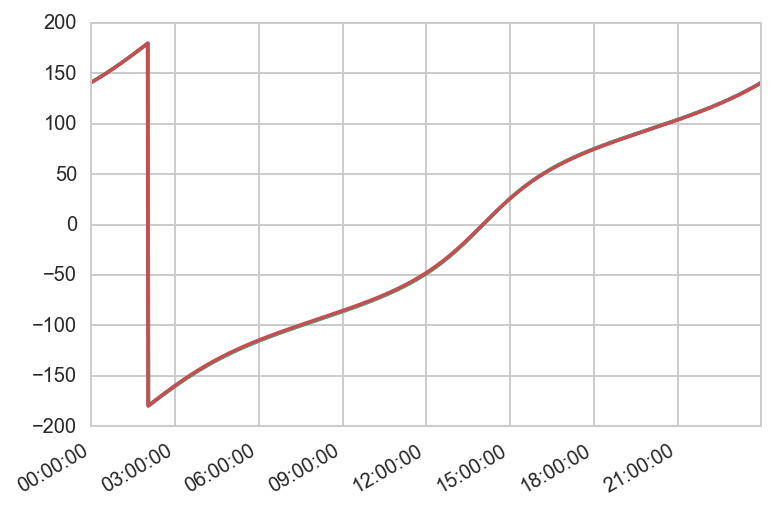

In [216]:
# Cambios a orientación Sur y sentido horario (0 = SUR, -90 = Este, 90 = Oeste)
(compara.azimuth_e - 180).plot()
(-compara.azimuth_ps.where(lambda x: x < -180, compara.azimuth_ps - 360) - 360).plot()
(-compara.azimuth_psf.where(lambda x: x > 180, compara.azimuth_psf + 360) + 360).plot()

                            azimuth_e  azimuth_ps  azimuth_psf
2016-09-05 00:00:00+02:00  321.118065 -141.123069   219.041860
2016-09-05 00:01:00+02:00  321.386929 -141.391957   218.770693
2016-09-05 00:02:00+02:00  321.656721 -141.661776   218.498575
2016-09-05 00:03:00+02:00  321.927470 -141.932528   218.225503
2016-09-05 00:04:00+02:00  322.199120 -142.204214   217.951475
_solar_azimuth TOOK: 0.006 s


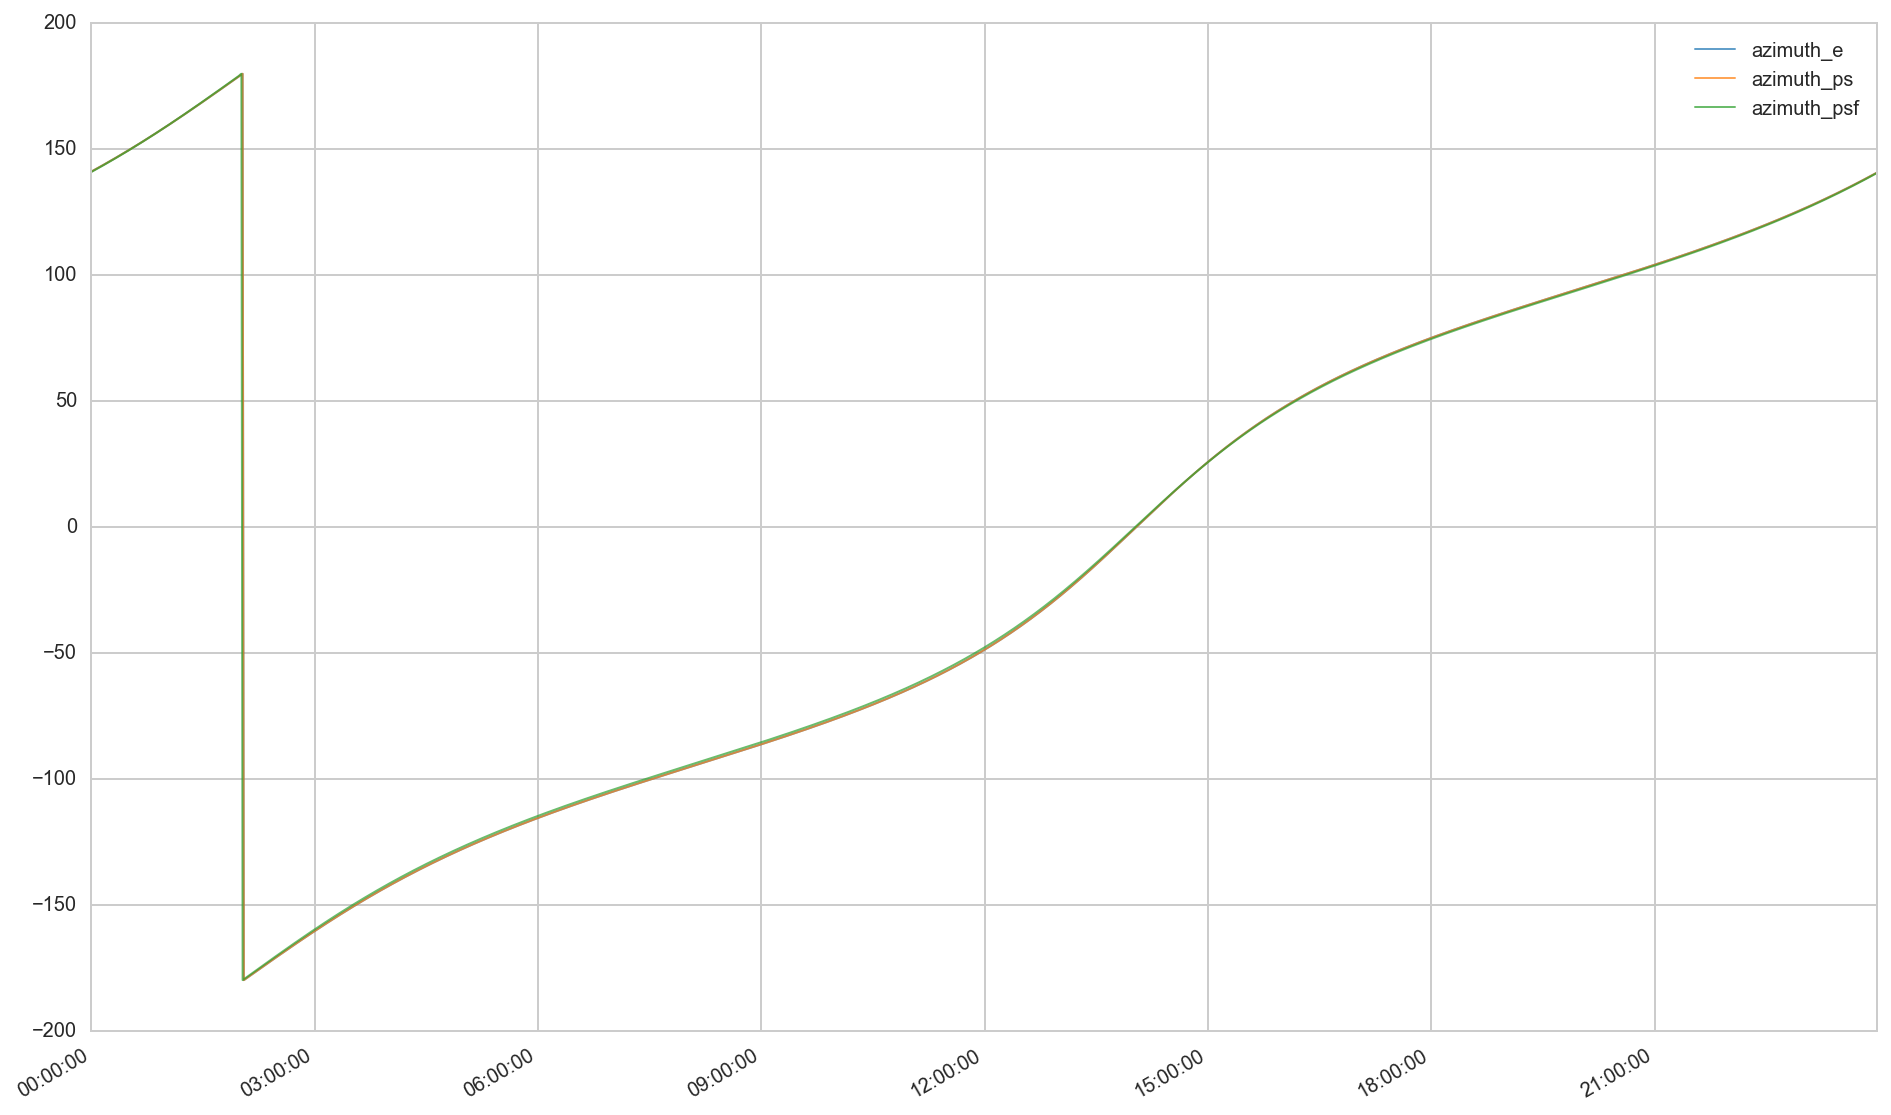

In [221]:
@timeit('_solar_azimuth', verbose=True)
def _solar_azimuth(azimut_s):
    azimut_s.azimuth_e -= 180
    azimut_s.azimuth_ps = -azimut_s.azimuth_ps.where(lambda x: x < -180, azimut_s.azimuth_ps - 360) - 360
    azimut_s.azimuth_psf = -azimut_s.azimuth_psf.where(lambda x: x > 180, azimut_s.azimuth_psf + 360) + 360
    return azimut_s

azimut_s = _solar_azimuth(compara[c_azimuts].copy())  # ['azimuth_e', 'azimuth_ps', 'azimuth_psf']
azimut_s.plot(figsize=FS, color=tableau20[:6:2], alpha=.7, lw=1)

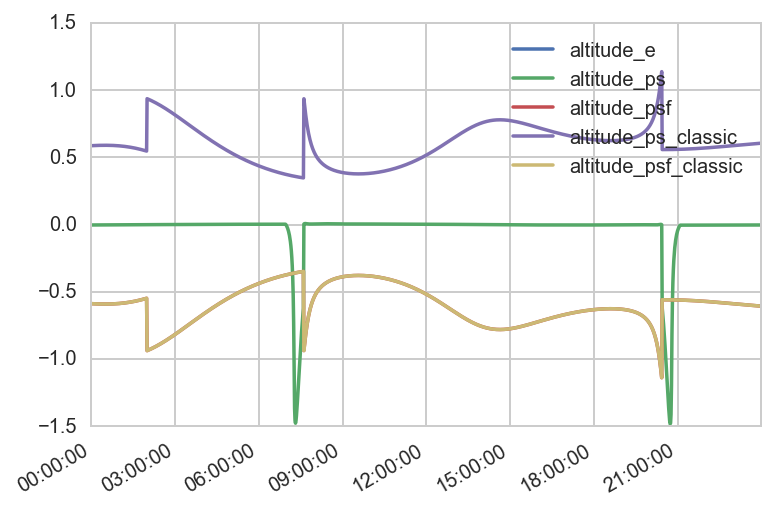

In [204]:
compara[cols_alt].diff(axis=1).plot()

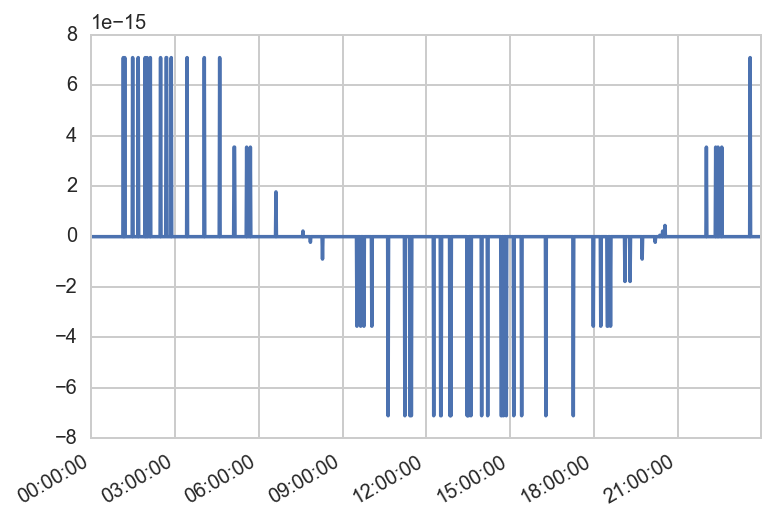

In [126]:
(compara.altitude_psf_classic - compara.altitude_psf).plot()

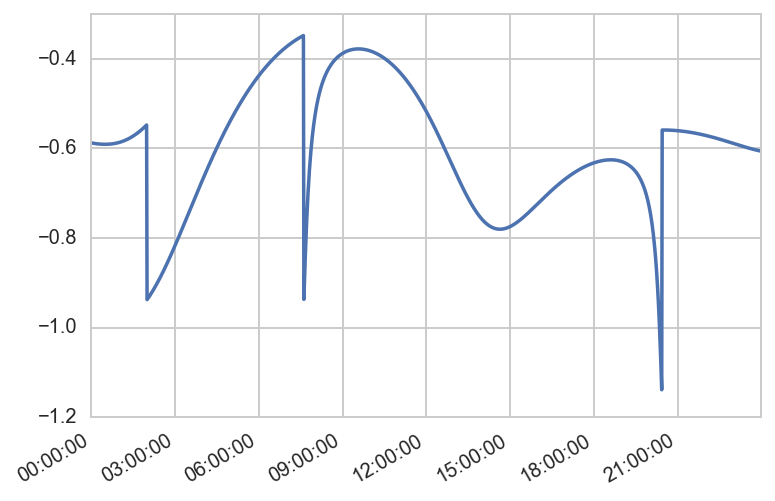

In [128]:
(compara.altitude_psf - compara.altitude_ps).plot()

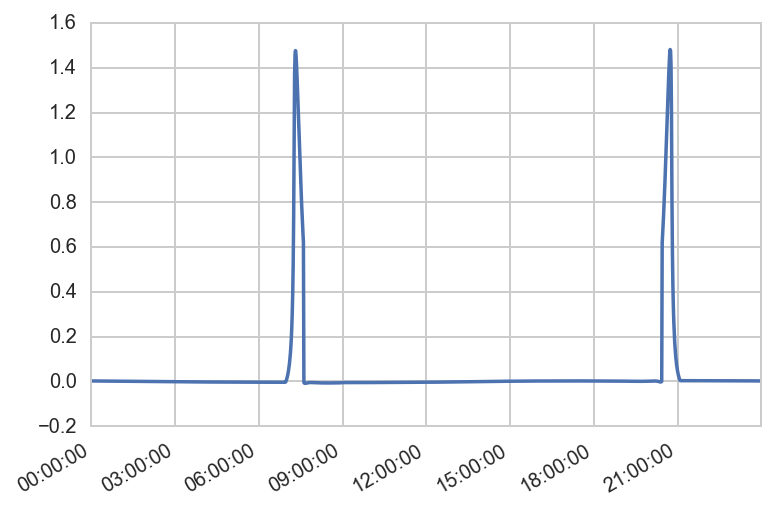

In [129]:
(compara.altitude_e - compara.altitude_ps).plot()

In [130]:
# +++

str_day = '2016-08-12'
tt = pd.DatetimeIndex(freq='1min', start=str_day, periods=60*24*40, tz=TZ)

df_ephem = _compute_alt_azi_ephem(tt)
df_ps = _compute_alt_azi_pysolar(tt)
df_psf = _compute_alt_azi_pysolar_f(tt)
df_ps_nch = _compute_alt_azi_pysolar_nch(tt)
df_ps_nch_f = _compute_alt_azi_pysolar_nch_fast(tt)



compute_alt_azi_ephem TOOK: 0.884 s


/Users/uge/anaconda/envs/py35/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


compute_alt_azi_pysolar TOOK: 16.129 s
compute_alt_azi_pysolar_fast TOOK: 1.047 s
compute_alt_azi_pysolar_nch TOOK: 30.729 s
compute_alt_azi_pysolar_nch_fast TOOK: 16.220 s


In [169]:
# Interpolate or calc?
@timeit('compute_alt_azi_ephem_interp', verbose=True)
def _compute_alt_azi_ephem_interp(tt, delta_n_calc=10):
    tt_utc = tt.tz_convert('UTC')
    here = ephem.Observer()
    here.lat = str(LAT)
    here.lon = str(LONG)
    here.elevation = ELEV_M
    sun = ephem.Sun()
    
    date_alt_azi = np.ones((len(tt), 2)) * np.nan
    for i, t in enumerate(tt_utc):
        if i % delta_n_calc == 0:
            here.date = ephem.Date(t)
            sun.compute(here)
            date_alt_azi[i, 0] = math.degrees(sun.alt)
            date_alt_azi[i, 1] = math.degrees(sun.az)
    df = pd.DataFrame(date_alt_azi, columns=['altitude_e_i', 'azimuth_e_i'], index=tt)
    return df.interpolate()
    

str_day = '2016-08-12'
tt = pd.DatetimeIndex(freq='1s', start=str_day, periods=60*24*60, tz=TZ)

df_ephem = _compute_alt_azi_ephem(tt)
df_ephem_i = _compute_alt_azi_ephem_interp(tt, delta_n_calc=60)
print(df_ephem_i.count())
df_psf = _compute_alt_azi_pysolar_f(tt)

compute_alt_azi_ephem TOOK: 1.439 s
compute_alt_azi_ephem_interp TOOK: 0.203 s
altitude_e_i    86400
azimuth_e_i     86400
dtype: int64
compute_alt_azi_pysolar_fast TOOK: 1.798 s


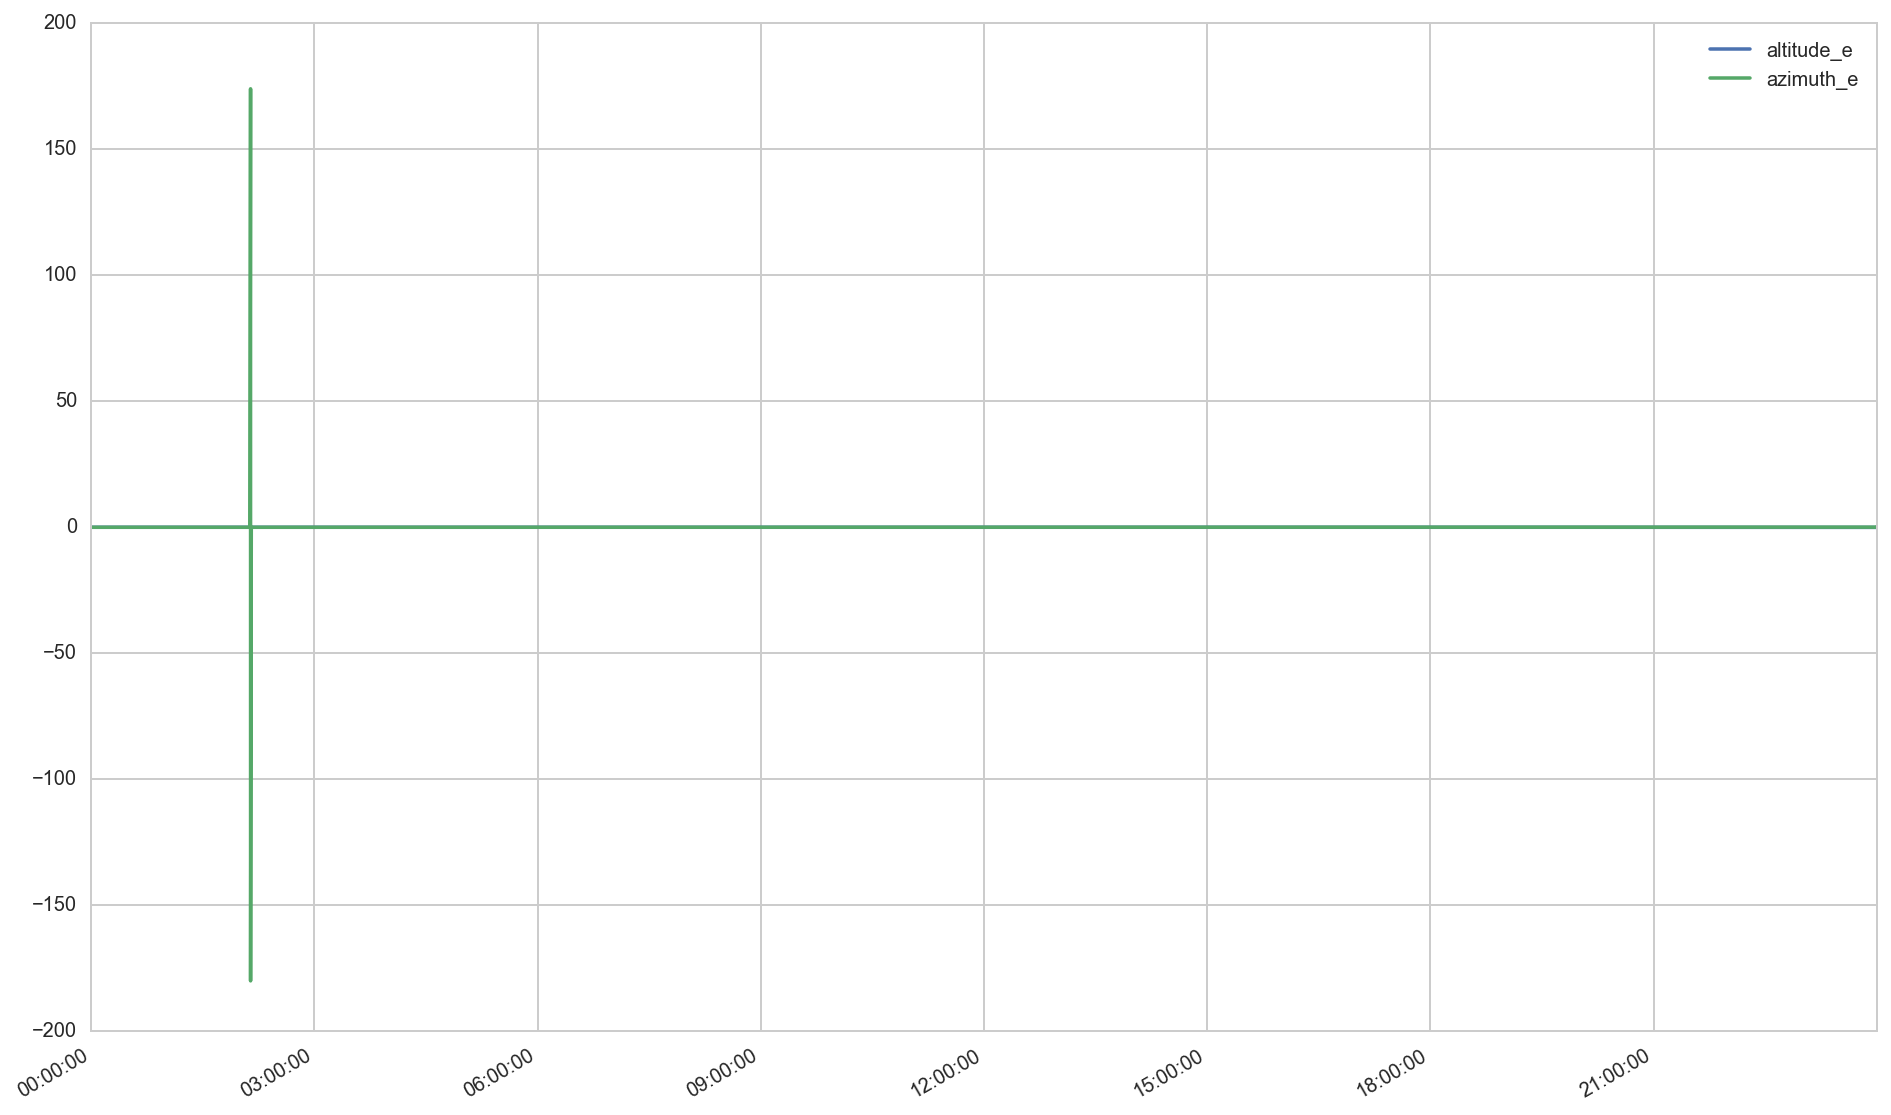

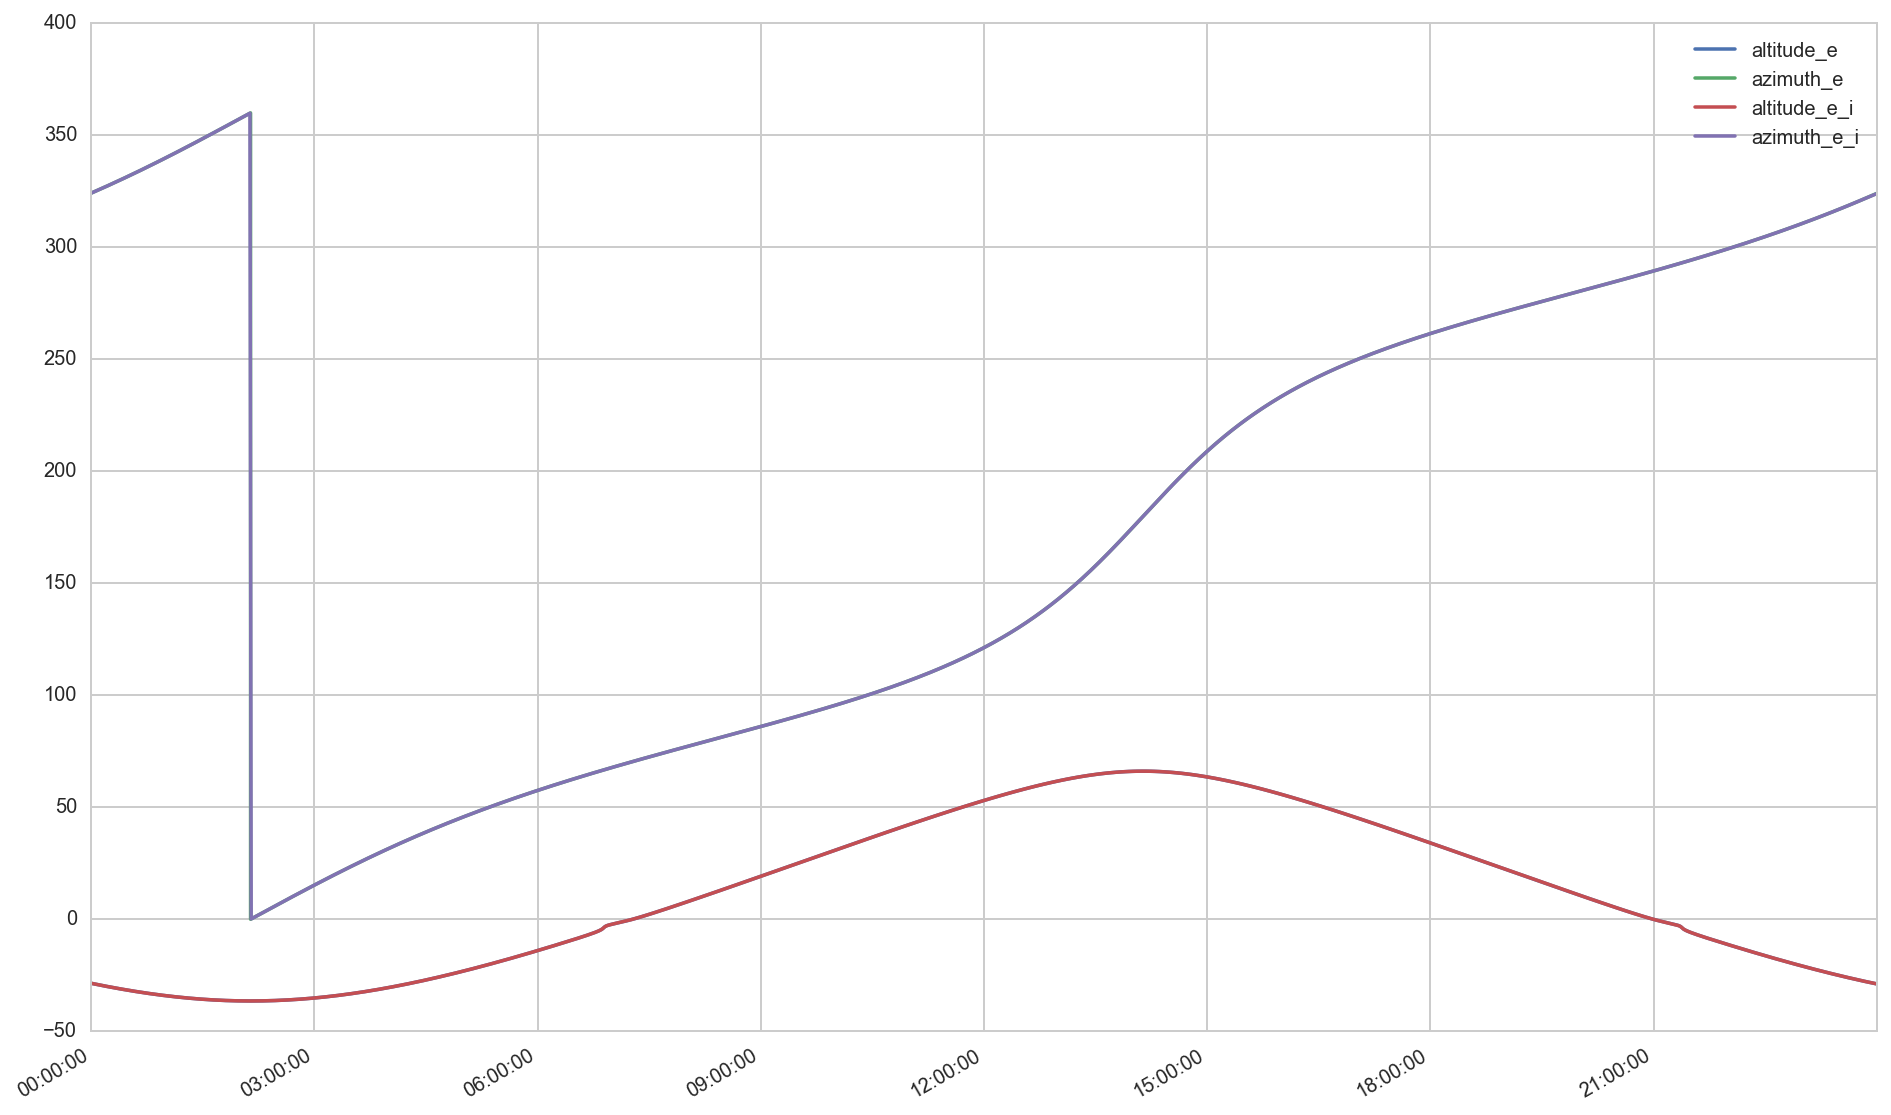

In [170]:
(df_ephem - df_ephem_i.values).plot(figsize=FS)
plt.show()

ax = df_ephem.plot(figsize=FS)
df_ephem_i.plot(ax=ax)

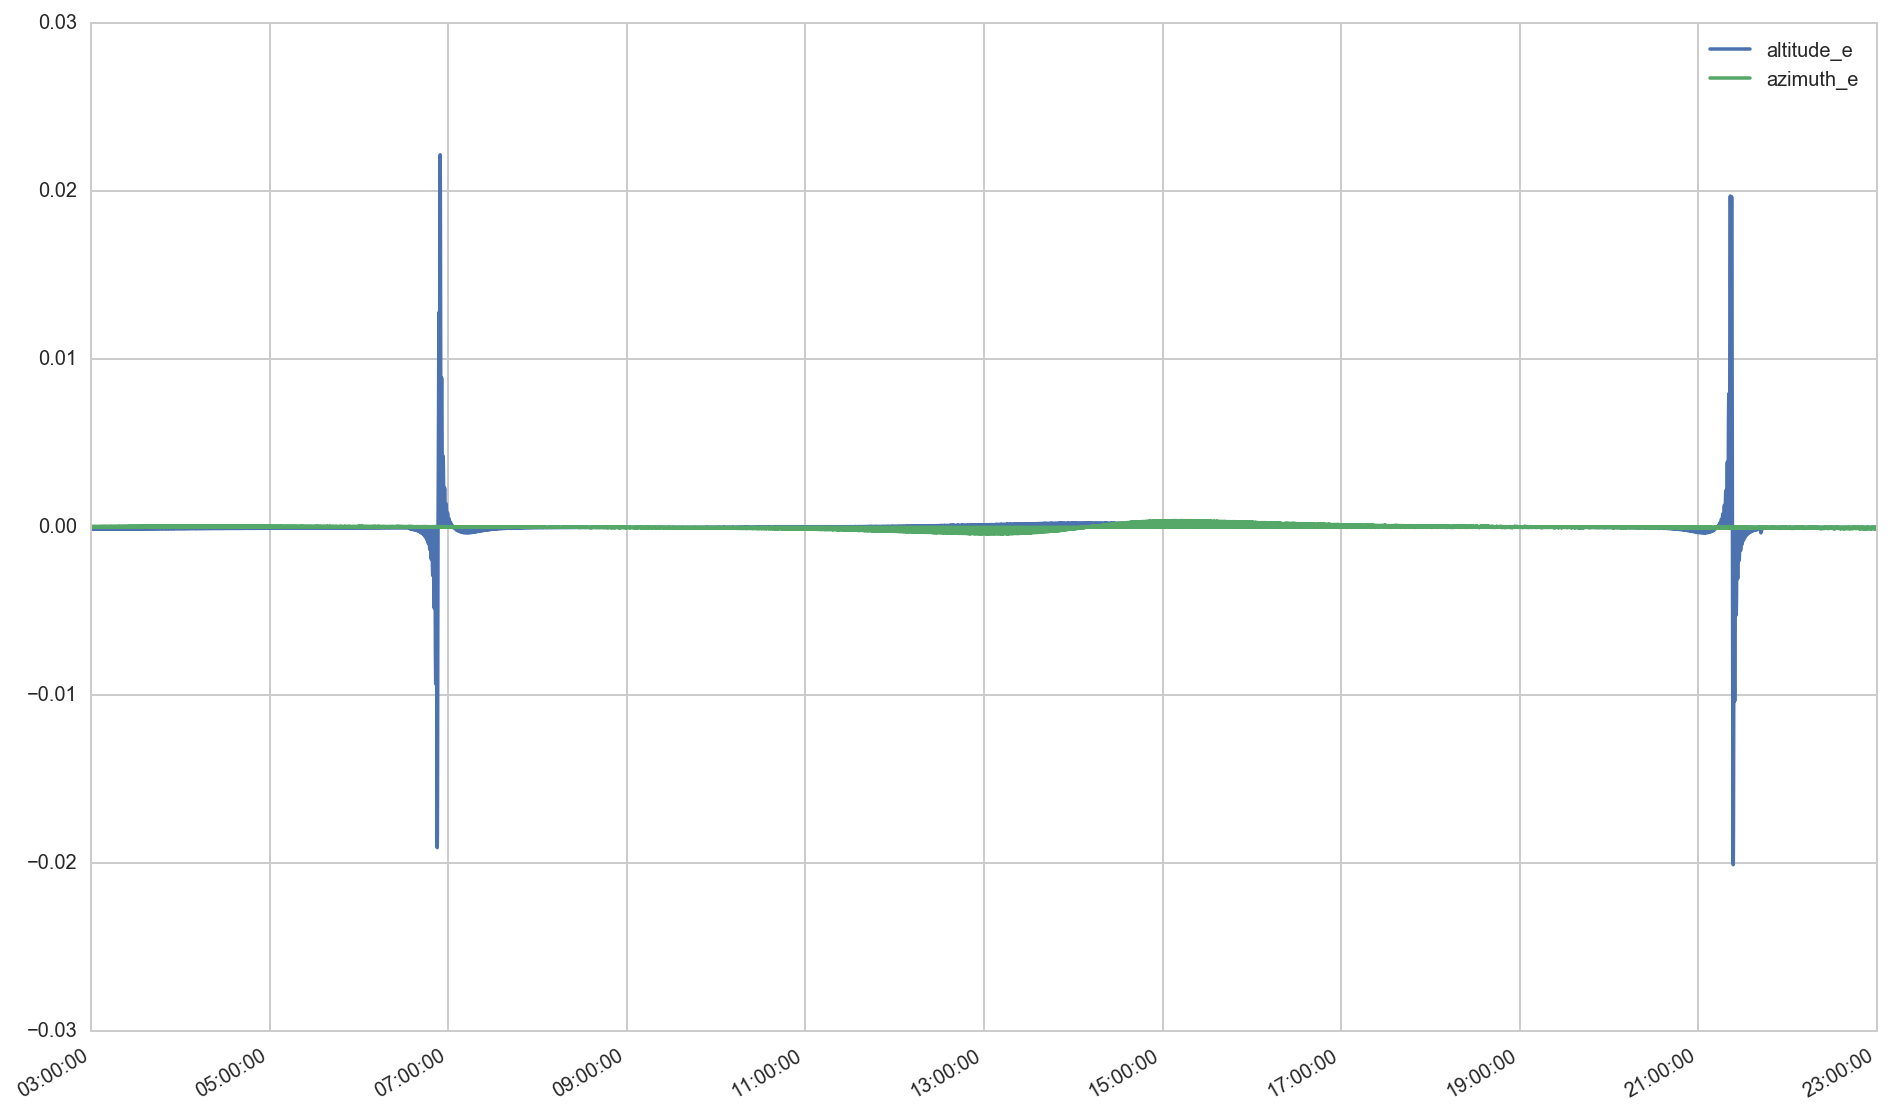

In [160]:
(df_ephem - df_ephem_i.values).between_time('3:00', '23:00').plot(figsize=FS)

In [171]:
# Big time series:
str_day = '2016-08-12'
tt = pd.DatetimeIndex(freq='1s', start=str_day, periods=60*24*60*30, tz=TZ)

df_ephem = _compute_alt_azi_ephem(tt)
df_ephem_i = _compute_alt_azi_ephem_interp(tt, delta_n_calc=120)

print_cyan(df_ephem_i.head())
df_ephem_i.tail()

compute_alt_azi_ephem TOOK: 43.201 s
compute_alt_azi_ephem_interp TOOK: 5.639 s
                           altitude_e_i  azimuth_e_i
2016-08-12 00:00:00+02:00    -28.585781   324.183400
2016-08-12 00:00:01+02:00    -28.587678   324.187449
2016-08-12 00:00:02+02:00    -28.589575   324.191498
2016-08-12 00:00:03+02:00    -28.591471   324.195547
2016-08-12 00:00:04+02:00    -28.593368   324.199596


,altitude_e_i,azimuth_e_i
2016-09-10 23:59:55+02:00,-38.445342,319.713642
2016-09-10 23:59:56+02:00,-38.445342,319.713642
2016-09-10 23:59:57+02:00,-38.445342,319.713642
2016-09-10 23:59:58+02:00,-38.445342,319.713642
2016-09-10 23:59:59+02:00,-38.445342,319.713642


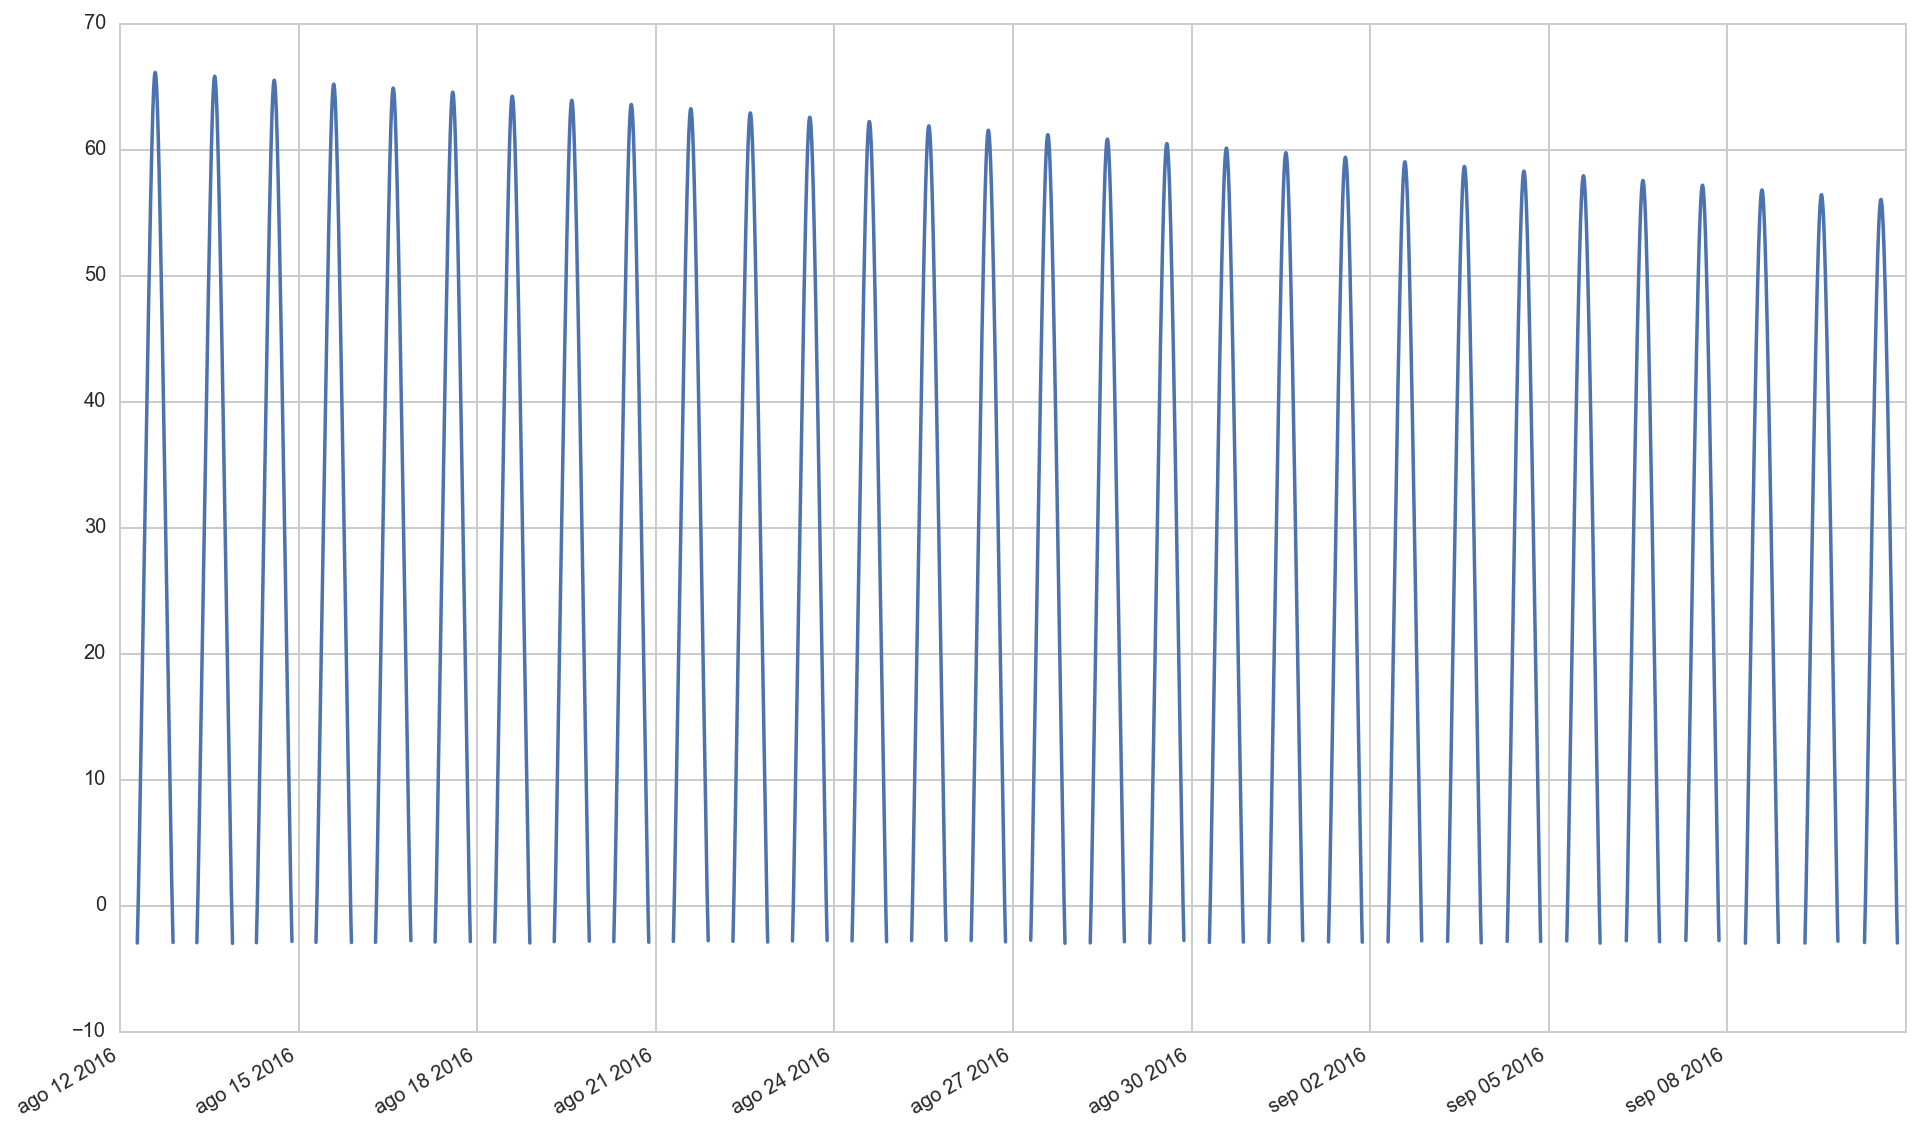

In [172]:
df_ephem_i.altitude_e_i.resample('1min').mean().where(lambda x: x > -3).plot(figsize=FS)

In [174]:
df_ephem_i.head()
df_ephem_i.resample('1min').mean().where(lambda x: x > -10).altitude_e_i.fillna(-10)

2016-08-12 00:00:00+02:00   -10.0
2016-08-12 00:01:00+02:00   -10.0
2016-08-12 00:02:00+02:00   -10.0
2016-08-12 00:03:00+02:00   -10.0
2016-08-12 00:04:00+02:00   -10.0
2016-08-12 00:05:00+02:00   -10.0
2016-08-12 00:06:00+02:00   -10.0
2016-08-12 00:07:00+02:00   -10.0
2016-08-12 00:08:00+02:00   -10.0
2016-08-12 00:09:00+02:00   -10.0
2016-08-12 00:10:00+02:00   -10.0
2016-08-12 00:11:00+02:00   -10.0
2016-08-12 00:12:00+02:00   -10.0
2016-08-12 00:13:00+02:00   -10.0
2016-08-12 00:14:00+02:00   -10.0
2016-08-12 00:15:00+02:00   -10.0
2016-08-12 00:16:00+02:00   -10.0
2016-08-12 00:17:00+02:00   -10.0
2016-08-12 00:18:00+02:00   -10.0
2016-08-12 00:19:00+02:00   -10.0
2016-08-12 00:20:00+02:00   -10.0
2016-08-12 00:21:00+02:00   -10.0
2016-08-12 00:22:00+02:00   -10.0
2016-08-12 00:23:00+02:00   -10.0
2016-08-12 00:24:00+02:00   -10.0
2016-08-12 00:25:00+02:00   -10.0
2016-08-12 00:26:00+02:00   -10.0
2016-08-12 00:27:00+02:00   -10.0
2016-08-12 00:28:00+02:00   -10.0
2016-08-12 00: